In [1]:
import os
os.chdir('../../')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import mlp,cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split

In [3]:
# X,Y =  make_circles(noise=0, factor=0.5, random_state=1,n_samples=200)

In [4]:
X,Y =  datasets.make_moons(200, noise=0.2)

X.shape,Y.shape

((200, 2), (200,))

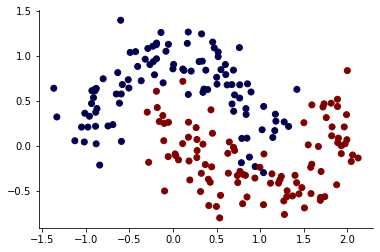

In [5]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap='seismic')
sns.despine()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [7]:
model = cmlp.cmlp([16,32,64,32,16,1],[nn.relu,nn.relu,nn.relu,nn.relu,nn.relu],[0,0,0,0,0])


In [8]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}


In [62]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.01, epochs=100, verbose=True)

Loss step 0:  0.68681806
Loss step 10:  0.3430655
Loss step 20:  0.28750932
Loss step 30:  0.26110864
Loss step 40:  0.2082362
Loss step 50:  0.12104077
Loss step 60:  0.073848605
Loss step 70:  0.054054826
Loss step 80:  0.04100287
Loss step 90:  0.034968212


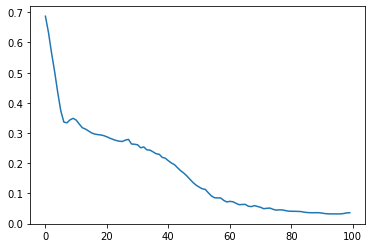

In [63]:
plt.plot(jnp.arange(0,100,1),loss)

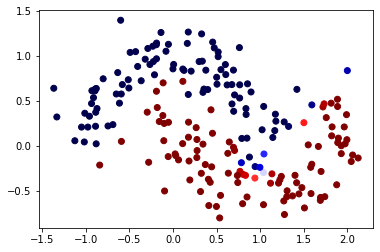

In [64]:
logits = model.apply(params, X, deterministic=True)
y_pred = nn.sigmoid(logits)

plt.scatter(X[:,0],X[:,1],c=y_pred,cmap='seismic')




In [65]:
from sklearn.metrics import brier_score_loss
brier_score_loss(Y,y_pred)


0.031076916308208653

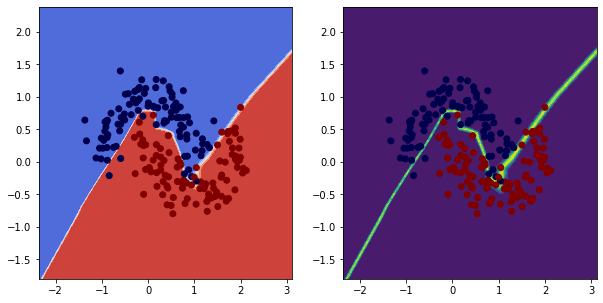

In [66]:
h=0.02
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))
Z =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True)
Z  = nn.sigmoid(Z)
Z_ = Z*(1-Z)
Z= Z.reshape(xx.shape)
Z_= Z_.reshape(xx.shape)
ax2.contourf(xx, yy, Z_,cmap='viridis')
ax1.contourf(xx, yy, Z,cmap='coolwarm')
# fig.colorbar()

ax1.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
ax2.scatter(X[:,0],X[:,1],c=Y,alpha=1,cmap='seismic')
# plt.ylim(-1.2,1.4)

In [88]:
params_lst= []
loss_lst =[]

for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X,deterministic=True)
    params,loss = fits.fit(model, params, auxs, learning_rate=0.01, epochs=100, verbose=False)
    params_lst.append(params)
    loss_lst.append(loss)

    

In [89]:
xx1 = jnp.linspace(-2.5, 3.5, 200)
xx2 = jnp.linspace(-2.0, 3, 200)
XX1, XX2 = jnp.meshgrid(xx1, xx2)

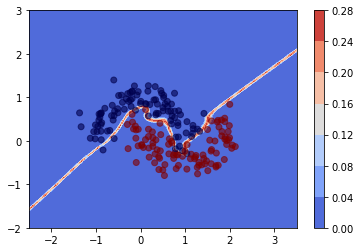

In [90]:
y_pred_grid_ensemble = []
for i in range(10):
    y_pred = nn.sigmoid(model.apply(params, jnp.c_[XX1.ravel(), XX2.ravel()],deterministic=True))
    y_pred_grid_ensemble.append(y_pred)
pred = jnp.array(y_pred_grid_ensemble).mean(axis=0)
sigma =  jnp.array(y_pred_grid_ensemble).std(axis=0)

Z = pred.reshape(XX1.shape)
Z__ = Z*(1-Z).reshape(XX1.shape)
Z_ = sigma.reshape(XX1.shape)
plt.contourf(XX1, XX2, Z__,cmap='coolwarm')
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c=Y,alpha=.6,cmap='seismic')
# plt.ylim(-1.2,1.3)


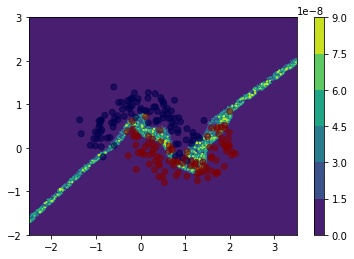

In [91]:
plt.contourf(XX1, XX2, Z_,cmap='viridis')
plt.colorbar()
plt.scatter(X[:,0],X[:,1],c=Y,alpha=.6,cmap='seismic')